In [27]:
# 1. Import 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os,datetime
from sklearn.metrics import classification_report

In [2]:
# 2. Load Dataset
Path = r"C:\Users\hariz\Desktop\Capstone3(ConcreteCrack)\dataset\Concrete Crack Images for Classification"


In [3]:
train_dir = os.path.join(Path)
validation_dir = os.path.join(Path)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 validation_split=0.2,
                                                                 subset="validation",
                                                                 seed=123,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


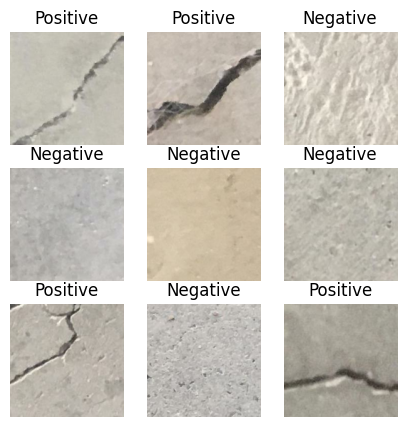

In [5]:
# 3. Inpsect some of the data
class_names = train_dataset.class_names
batch_1 = train_dataset.take(1)

plt.figure(figsize=(5, 5))
for images, labels in batch_1:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# 4 Further split the validation dataset into val-test splits
nBatches = validation_dataset.cardinality().numpy()

val_dataset = validation_dataset.take(nBatches//2)
test_dataset = validation_dataset.skip(nBatches//2)

In [7]:
# 5 Convert val and test dataset to prefetch dataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# 6 Create the data augmentation layers
data_augmentation = tf.keras.Sequential()
data_augmentation = keras.layers.RandomFlip('horizontal')         
data_augmentation = keras.layers.RandomRotation(0.2)

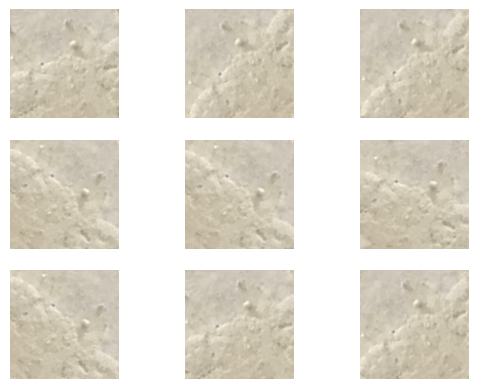

In [9]:
# 7 Lets test out the data augmentation layers
for images, labels in train_dataset.take(1):
    first_image = images[0]
    plt.figure()
    for i in range(9):
        plt.subplot(3,3,i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
plt.show()


In [10]:
# 8 Create the preprocess input layer for mobilenet v2

preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [11]:
# 9 Perform transfer learning
# (A) Create the feature extractor from the pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# (B) Add in out own classifier
global_avg = keras.layers.GlobalAveragePooling2D()
output_layer = keras.layers.Dense(2,activation='softmax')

In [13]:
# (C) Use functional API to connect the layers together to form a pipeline

# a. Begin with input
inputs = keras.Input(shape=IMG_SHAPE)

# b. Augmentation
x = data_augmentation(inputs)

# c. Preprocess layer
x = preprocess_input(inputs)

# d. Feature extractor
x = base_model(x)

# e. Classifier
x = global_avg(x)

outputs = output_layer(x)

model = keras.Model(inputs= inputs, outputs= outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

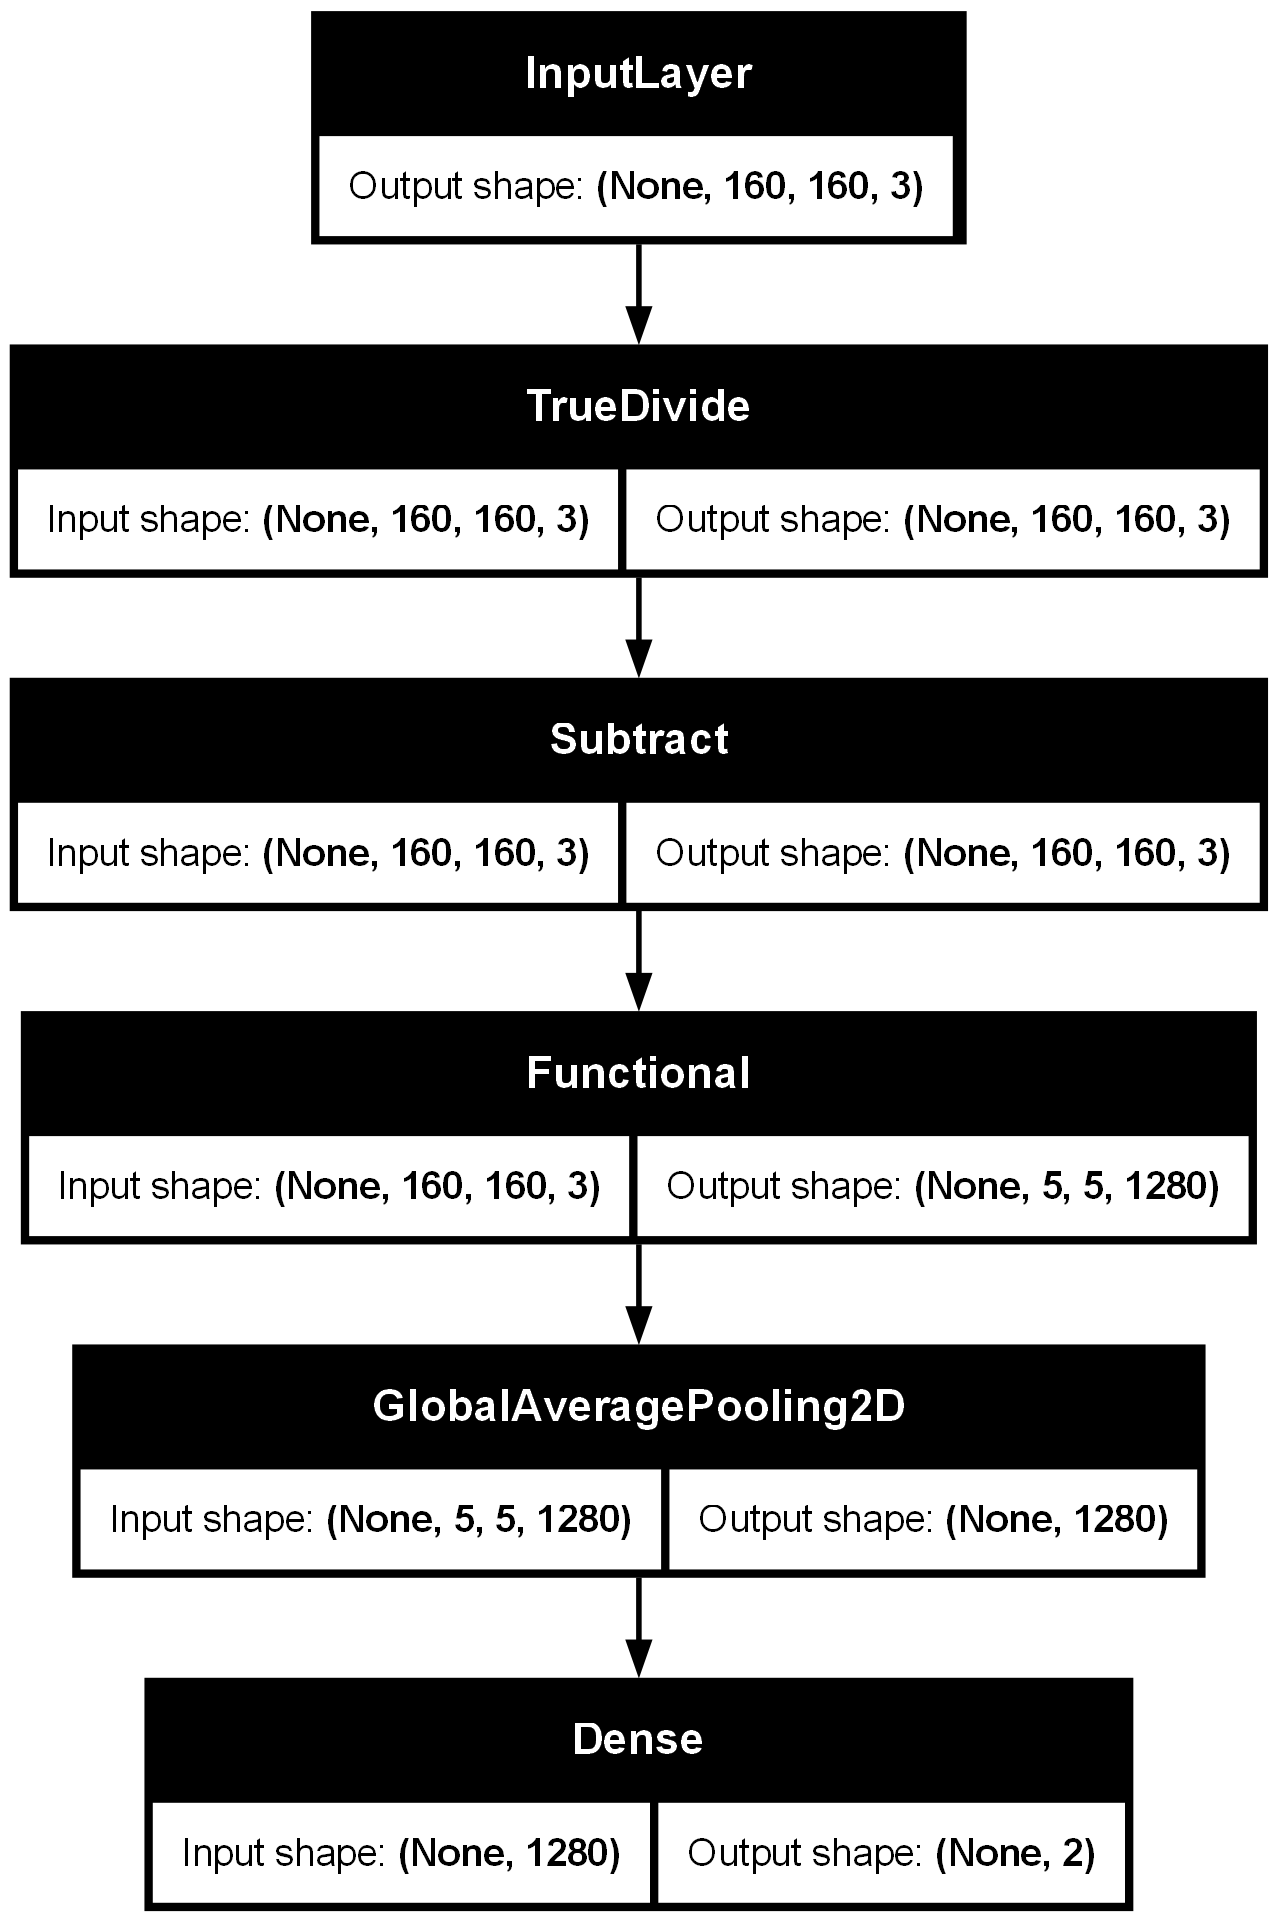

In [14]:
plot_model(model ,show_shapes=True, to_file="model.png")

In [15]:
# 10 Model compile
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Define the callbacks
logpath = "tensorboard/ConcreteCrack/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [17]:
# Evaluate the model before training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.1459 - loss: 1.4610


[1.4571424722671509, 0.15049999952316284]

In [ ]:
# 11. First stage of training
EPOCH =100
history_first = model.fit(train_dataset,validation_data=val_dataset, epochs=EPOCH, callbacks=[tb,es])

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 213s 210ms/step - accuracy: 0.8573 - loss: 0.2915 - val_accuracy: 0.9967 - val_loss: 0.0163
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - accuracy: 0.9967 - loss: 0.0130 - val_accuracy: 0.9977 - val_loss: 0.0101
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 188s 188ms/step - accuracy: 0.9977 - loss: 0.0081 - val_accuracy: 0.9977 - val_loss: 0.0081
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 189s 189ms/step - accuracy: 0.9982 - loss: 0.0062 - val_accuracy: 0.9977 - val_loss: 0.0070
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 189s 189ms/step - accuracy: 0.9983 - loss: 0.0051 - val_accuracy: 0.9980 - val_loss: 0.0063
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 189s 189ms/step - accuracy: 0.9986 - loss: 0.0043 - val_accuracy: 0.9980 - val_loss: 0.0063
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 190s 190ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9985 - val_loss: 0.0052
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 194s 194ms/s

In [19]:
# Evaluate the model before training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.9992 - loss: 0.0037


[0.004293488338589668, 0.9990000128746033]

In [20]:
# 12 Proceed with second stage of training
# (A) Unfreeze the base model
base_model.trainable = True

# (B) Freeze the deeper layers inside the base model
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [21]:
# Recompile the model, this time we will choose a different optimizer
rms = keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# (C) Run the second stage of training
fine_tune_epoch = 10
total_epoch = EPOCH + fine_tune_epoch
history_fine = model.fit(train_dataset, validation_data=validation_dataset, epochs= total_epoch, initial_epoch=history_first.epoch[-1], callbacks=[es,tb])

Epoch 27/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 314s 308ms/step - accuracy: 0.9881 - loss: 0.0609 - val_accuracy: 0.9866 - val_loss: 0.3725
Epoch 28/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 304s 304ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9951 - val_loss: 0.1078
Epoch 29/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 298s 298ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9986 - val_loss: 0.0315
Epoch 30/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 295s 295ms/step - accuracy: 0.9997 - loss: 6.8404e-04 - val_accuracy: 0.9987 - val_loss: 0.0079
Epoch 31/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 296s 296ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0095
Epoch 31: early stopping


In [23]:
history_fine = model.fit(train_dataset, validation_data=validation_dataset, epochs= total_epoch, initial_epoch=len(history_fine.epoch)+len(history_first.epoch), callbacks=[es,tb])

Epoch 33/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 301s 301ms/step - accuracy: 0.9999 - loss: 2.4931e-04 - val_accuracy: 0.9985 - val_loss: 0.0105
Epoch 34/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 296s 296ms/step - accuracy: 0.9999 - loss: 1.5475e-04 - val_accuracy: 0.9994 - val_loss: 0.0098
Epoch 35/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 298s 298ms/step - accuracy: 0.9999 - loss: 4.2624e-04 - val_accuracy: 0.9992 - val_loss: 0.0087
Epoch 36/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 298s 298ms/step - accuracy: 0.9999 - loss: 2.4712e-04 - val_accuracy: 0.9990 - val_loss: 0.0094
Epoch 37/110
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 297s 297ms/step - accuracy: 0.9999 - loss: 2.2643e-04 - val_accuracy: 0.9994 - val_loss: 0.0096
Epoch 37: early stopping


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
[0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1]
['Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive']


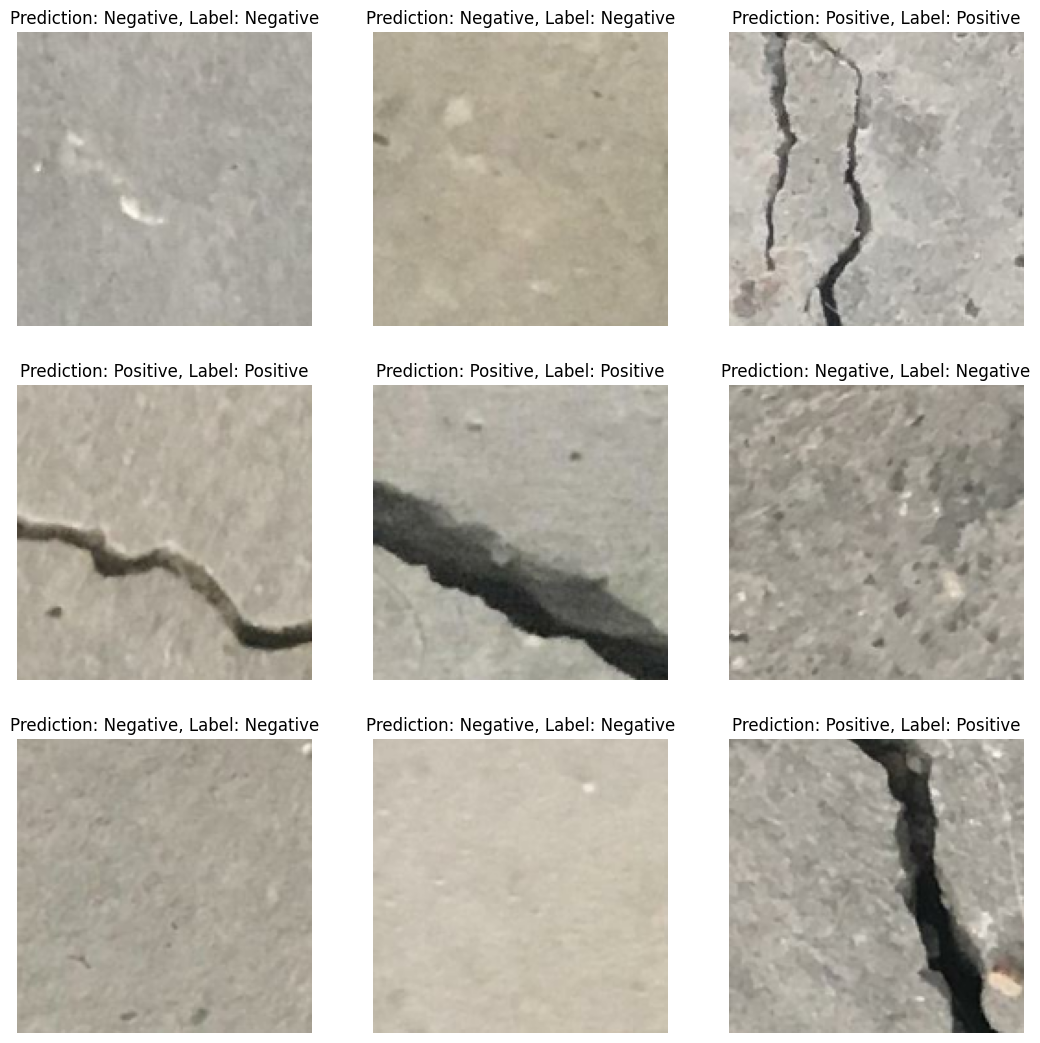

In [ ]:
# 13. Make predictions with test data
for image_batch, labels_batch in test_dataset.take(1):
    prediction = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in prediction]
print(prediction)
print(predicted_class)

plt.figure(figsize=(13,13))
for i in range(9):
    plt.subplot(3,3, i +1)
    plt.axis('off')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Prediction: {predicted_class[i]}, Label: {class_names[labels_batch[i]]}")

In [ ]:
# 14. Classification report
model_report = classification_report(labels_batch,prediction)
print(model_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
# 15. Save model in .h5
keras.models.save_model(model, "model/ConcreteCrack.h5")